In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statsmodels.api as sm
from pyramid.arima import auto_arima
from pandas import datetime
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
import multiprocessing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id':"19Z9udK0dnwVGp7MsH5bcNFabmARUCT-h"})
downloaded.GetContentFile('train_2.csv') 

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
              else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def import_data(file):
  """create a dataframe and optimize its memory usage"""
  df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
  df = reduce_mem_usage(df)
  return df

In [5]:
df_original = import_data("train_2.csv")
df_original

Memory usage of dataframe is 889.82 MB
Memory usage after optimization is: 451.02 MB
Decreased by 49.3%


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,3.0,2.0,3.0,4.0,3.0,2.0,2.0,0.0,3.0,1.0,1.0,0.0,2.0,2.0,1.0,6.0,2.0,3.0,3.0,2.0,7.0,6.0,8.0,5.0,7.0,7.0,7.0,8.0,2.0,0.0,4.0,3.0,6.0,5.0,2.0,4.0,4.0,8.0,2.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,6.0,1.0,2.0,3.0,3.0,18.0,4.0,5.0,3.0,2.0,1.0,3.0,2.0,1.0,2.0,2.0,2.0,1.0,3.0,9.0,10.0,8.0,6.0,3.0,9.0,2.0,11.0,3.0,3.0,4.0,4.0,7.0

In [20]:
#This dataset is having missing vaues so here I am Making a copy of dataframe by dropping 'page' column so that we can get total no. of cells to check percentage of missing values in the given data.
df_drop_page = df_original.drop(['Page'], axis=1)
df_drop_page.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,10.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,12.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,4.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,8.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [7]:
#This function will give us the percentage of missing values in toal datatset.
def missing_value_percent(df_1, df_2):
  total_columns = len(df_2.count())
  total_rows = len(df_2.index)
  total_count = total_columns*total_rows
  print("Total record/cells:", total_count)

  missing_count = df_1.isnull().sum().sum()
  print("cells which are having missing values as NaN:", missing_count)

  missing_values_percent = (missing_count/total_count)*100
  print("percent of missing values in whole dataset:", missing_values_percent)
  # return missing_values_percent

In [10]:
 #Above function call.
 missing_value_percent(df_original, df_drop_page)

Total record/cells: 116485589
cells which are having missing values as NaN: 7027348
percent of missing values in whole dataset: 6.032804624441569


Here as we can see that this dataset is having only 6% of missing values which could be taken into into analysis. A missing value may mean the traffic was zero or that the data is not available for that day.

So we are not removing them for now.

Now in the original dataframe "page" column contains wikipedia page names where every page name contains four parts title, language, access, agent. We will saperate them and plot to visualize the dataset.



In [8]:
#This fuction will breakdown the details of every artical name in the page column and give us access-type, agent-type and language for every artical name.
def artical_breakdown(df):
  agent_type = []
  access_type = []
  language = []
  for i in df['Page']:
    wikipedia_article = i
    wikipedia_article_split_lst = wikipedia_article.split('_')
    agent_type.append(wikipedia_article_split_lst[-1]) 
    access_type.append(wikipedia_article_split_lst[-2])
    language_wikipedia = wikipedia_article_split_lst[-3]
    for j in language_wikipedia:
      language_split = language_wikipedia.split('.')
    language.append(language_split[-3])
  dict = {'agent_type': agent_type, 'access_type': access_type, 'language': language}  
  df_after_artical_split = pd.DataFrame(dict)
  return df_after_artical_split

In [9]:
#Above funtion call.
# pd.set_option('display.max_colwidth',145063)
df_after_artical_split = artical_breakdown(df_original)
df_after_artical_split

,agent_type,access_type,language
0,spider,all-access,zh
1,spider,all-access,zh
2,spider,all-access,zh
3,spider,all-access,zh
4,spider,all-access,zh
...,...,...,...
145058,spider,all-access,es
145059,spider,all-access,es
145060,spider,all-access,es
145061,spider,all-access,es


Now as the part of data visualization, we will check all the unique language, type of access and type of the agent in the dataset.
By doing this we can understand the popularity of the pages.


---



In [10]:
unique_agent_type = df_after_artical_split['agent_type'].unique()
unique_access_type = df_after_artical_split['access_type'].unique()
uniuqe_language = df_after_artical_split['language'].unique()
print(unique_agent_type)
print(unique_access_type)
print(uniuqe_language)

['spider' 'all-agents']
['all-access' 'desktop' 'mobile-web']
['zh' 'fr' 'en' 'commons' 'ru' 'www' 'de' 'ja' 'es']


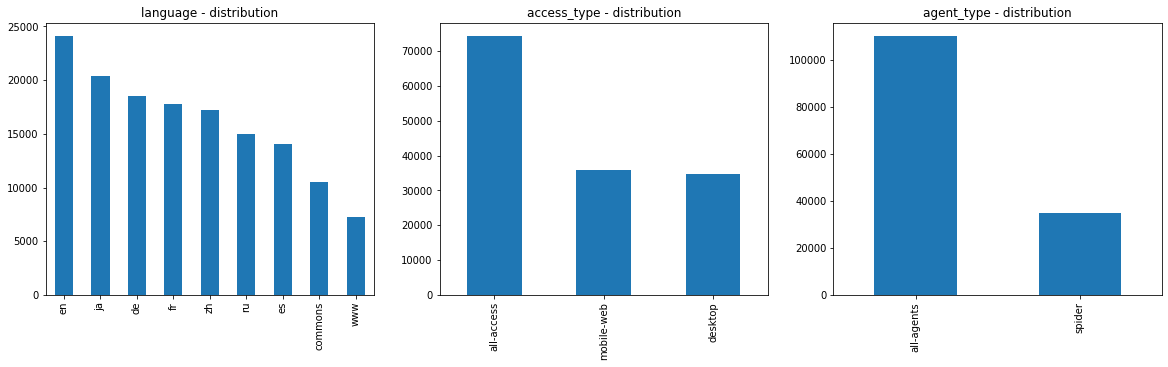

In [11]:
plt.figure(figsize = (20,5))
plt.subplot(131)
df_after_artical_split['language'].value_counts().plot.bar().set_title('language - distribution')
plt.subplot(132)
df_after_artical_split['access_type'].value_counts().plot.bar().set_title('access_type - distribution')
plt.subplot(133)
df_after_artical_split['agent_type'].value_counts().plot.bar().set_title('agent_type - distribution')
plt.show()


Above bar graphs show that there are more pages for english language than any other language followed by japanese and so on. In the language-distribution graph 'commons'and 'www' are wikimedia pages which are less thne any other language. Mobile sites are slightly more frequent than desktop ones.

In [12]:
df_concat = pd.concat((df_original, df_after_artical_split), axis = 1)
df_concat.head(2)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,agent_type,access_type,language
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0,spider,all-access,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0,spider,all-access,zh


From the above graph we know that how many pages are there for every language. Now let's check see the influence of the language on the page views. For which we are calculating mean for all the views for every date for every language and plotting them.

In [13]:
df_mean = df_concat.groupby('language').mean()
df_mean

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
language,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
commons,156.426849,162.411087,156.154587,130.496155,146.400436,165.648056,171.841476,186.470764,162.596130,157.597168,124.979553,130.747101,155.696091,172.264450,182.979797,171.141769,199.181717,182.628876,164.587173,157.116516,200.321976,221.933746,187.740036,176.536789,165.594711,156.161819,197.719635,183.953156,189.015961,185.403412,350.614319,193.561676,377.391815,188.156433,220.385040,229.122314,265.310547,268.397827,345.669983,241.735168,...,171.215805,229.638016,294.341309,162.104935,163.836273,215.253021,172.473358,160.145874,157.016617,163.776016,149.747482,300.459442,341.217438,863.342957,364.329651,258.641571,275.101044,182.984879,260.915894,385.287811,181.114563,252.261887,158.111160,189.451462,163.317520,160.593933,186.628433,166.488113,240.953369,312.106171,396.205048,222.732773,264.242767,233.352371,180.871735,457.383667,1225.242676,195.397202,240.687088,202.182373
de,801.433533,790.469299,758.689941,697.106323,809.890381,890.095276,863.250549,876.393799,842.164856,785.139832,726.604736,861.899902,938.977112,895.891907,835.984009,826.988525,851.874451,1000.639526,945.781311,867.191711,806.395203,823.092041,800.592957,758.981262,753.465637,788.995850,844.202209,836.172607,833.432190,797.626770,747.804138,730.849609,757.189941,787.388916,832.647339,798.679932,803.619873,819.757812,739.997375,826.326294,...,611.291687,617.254761,624.294373,635.957214,687.021423,669.969055,660.395142,630.837646,665.514526,647.317383,610.753845,653.000732,653.081299,646.099487,630.330139,639.771423,606.589417,572.603577,655.127930,653.101074,616.404541,603.675598,610.555786,589.736938,540.916260,611.627380,655.958740,622.621338,639.603943,668.955811,723.562256,607.375793,667.190918,676.608765,658.517822,670.170044,771.322510,632.329224,589.166992,661.035400
en,4120.242676,4096.969727,3863.318848,4020.385498,4157.757812,4462.850098,4262.741699,3990.764404,4068.850342,4043.516846,4070.139404,4480.256836,4432.330078,4460.478027,4120.769531,4170.400391,3997.403564,3867.979736,4104.826660,4285.880859,4072.901123,3984.916016,3913.217285,3827.585938,3839.767334,4138.803223,4208.461914,4113.844727,4791.615234,3772.633057,3650.296875,3670.316406,4011.553711,3799.913330,4071.259277,4071.603027,4075.058594,4152.646973,3966.314697,4109.713379,...,3396.540039,3179.674805,3040.236328,3140.440674,3500.423096,3702.904297,3598.150635,3673.689209,3447.781006,3204.973145,3457.606934,3534.590332,3615.210449,3556.527344,3583.467285,3438.897461,3169.443848,3310.049561,3521.789795,3667.776123,3505.547852,3432.084961,3223.022949,3120.807861,3394.123291,3709.912842,3864.802002,3594.065186,3453.435059,3345.578857,3286.895020,3510.709717,4141.146973,4172.079102,3909.095703,3934.870117,4123.490234,3092.367676,2990.546875,3454.202881
es,1176.993530,1125.926392,1035.044434,972.426575,1056.349121,1204.096069,1174.570312,1139.170044,1117.413208,1015.597046,913.589233,1040.569214,1180.397705,1239.625610,1170.270264,1115.124023,1003.507751,872.649536,933.635681,1097.362061,1086.993652,1117.632202,1049.098022,93

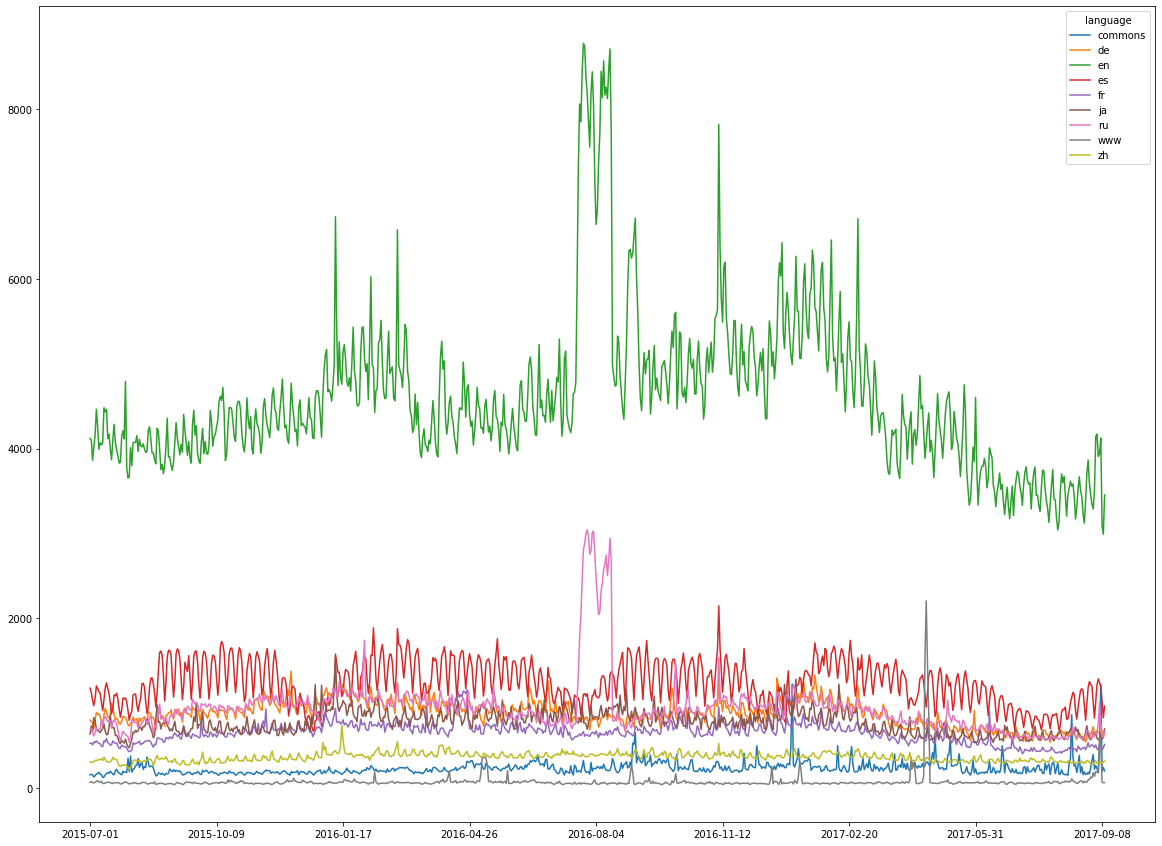

In [14]:
df_mean.T.plot(figsize=(20, 15))

Here we can see that english language pages are having large no. of hits with which it could be said that english language pages are would be going to get more hits then any other language in the future.

One more thing to be noticed here is that russin ang english language pages are having high spikes at the same time.

Following taking small part of the data to work with due to memory constraint.

In [6]:
sample_df = df_original.head(10)
sample_df = sample_df.reset_index()
sample_df = sample_df.drop(['index'], axis=1)
sample_df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,7.0,12.0,11.0,7.0,9.0,6.0,10.0,8.0,13.0,3.0,14.0,4.0,9.0,14.0,10.0,8.0,3.0,74.0,17.0,8.0,6.0,9.0,3.0,10.0,21.0,9.0,5.0,3.0,4.0,1.0,...,41.0,35.0,18.0,18.0,15.0,16.0,13.0,14.0,29.0,18.0,28.0,21.0,10.0,19.0,13.0,8.0,54.0,19.0,14.0,41.0,32.0,46.0,31.0,29.0,31.0,28.0,17.0,16.0,8.0,13.0,13.0,13.0,45.0,4.0,13.0,20.0,18.0,17.0,14.0,11.0
6,91Days_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.0,33.0,8.0,7.0,5.0,12.0,7.0,9.0,11.0,8.0,10.0,10.0,7.0,51.0,12.0,10.0,14.0,11.0,9.0,9.0,9.0,68.0,8.0,40.0,6.0,14.0,11.0,6.0,9.0,7.0,12.0,8.0,5.0,7.0,8.0,10.0,8.0,5.0,3.0,5.0
7,A'N'D_zh.wikipedia.org_all-access_spider,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,32.0,17.0,23.0,47.0,33.0,47.0,58.0,29.0,187.0,128.0,34.0,38.0,8.0,38.0,17.0,45.0,14.0,15.0,56.0,30.0,15.0,115.0,6.0,25.0,10.0,135.0,40.0,63.0,32.0,35.0,...,43.0,33.0,20.0,

Splitting the data based on date. 95% of the total columns kept for training and rest 5% for validation. So finally we will have 2015-07-01 to 2017-07-31 for training. And 2017-08-01 to 2017-09-10 for validation

In [7]:
# Generate train and validate dataset
def get_train_validate_set(df, train_percent):
    df = df.drop(['Page'], axis=1)
    train_end = math.floor(((df.shape[1]) * train_percent)/100)
    train_df = df.iloc[:, np.r_[:train_end]]
    print("train_df:", train_df.shape)
    test_df = df.iloc[:, np.r_[train_end:df.shape[1]]]
    
    print("test_df:", test_df.shape)

    return train_df, test_df

In [8]:
train_df_small, test_df_small = get_train_validate_set(sample_df, 95)
print(train_df_small.shape)
print(test_df_small.shape)

train_df: (10, 762)
test_df: (10, 41)
(10, 762)
(10, 41)


Extracting date and views from every row which is an individual page series.

In [9]:
# Funtion to get train and test series for a given index(i.e. for one page based on index).
def extract_page_series(df, row_num, start_idx):
    values = df.iloc[row_num, start_idx:]
    df = pd.DataFrame({ 'date': values.index, 'y': values.values})
    return df

Above function will return a dataframe for every page which would have 2 columns 'date' and 'y' where y column is having hits for that particular page.

In [11]:
# Function to get a dictionary where row index of the 'train_df_small' is key and the dataframe for the respective index is the value of the dictionary.
def page_series(df):
  page_dic = {}
  for indax, row in df.iterrows():
    # print(indax)
    # print(row)
    train_data = extract_page_series(df,indax, 0)
    # print(train_data)
    # print(index)
    for col in train_data.columns[0:]:
      train_data[col] = train_data[col].fillna(0)
      page_dic[indax] = train_data 
  return page_dic

Above 'page_dic' is a dictionary having index as their keys and dataframe for each page series as their values.


In [12]:
# This function is returning filtered dataframes for every key in the 'page_dic'.
def remove_outliers(page_dic):
  filtered_page_dic = {}
  # filtered_page_dic = dict.fromkeys(page_dic)
  for key, train_data in page_dic.items():
    # print(train_data)
    train_data["date"] = pd.to_datetime(train_data.date)
    train_data.set_index("date", inplace = True)
    isolation_forest_model = IsolationForest(contamination=0.08)

    isolation_forest_model.fit(train_data)
    train_data['anomaly'] = isolation_forest_model.predict(train_data)
    # train_data
    anomaly=train_data.loc[train_data['anomaly']==-1]
    anomaly_index=list(anomaly.index)
    # print(anomaly.shape)
    train_data_filtered = train_data[train_data['anomaly'] == 1]
    train_data_filtered.reset_index(level = 0, inplace = True, col_level = 1)
    train_data_filtered = train_data_filtered.drop(['anomaly'], axis = 1)
    convert_dict = {'y': float}
    
    train_data_filtered = train_data_filtered.astype(convert_dict)
    # train_data_filtered['y'] = train_data_filtered['y'].replace({0:np.nan})

    # train_data_filtered['y'] = train_data_filtered['y'].apply(lambda x: np.log(x))
    
    filtered_page_dic[key] = train_data_filtered 

    # print(train_data_filtered)
  return filtered_page_dic

Above 'filtered_page_dic' is a dictionary with same keys in the 'page_dic' but having filtered dataframe as their values.

In [13]:
# This function fits and returns the model for every dataframe.
def train_model(dic):
  trained_model = {}
  for key, train_data_filtered in dic.items():
    # print(train_data_filtered)
    train_series = train_data_filtered.y
    # print(train_series)
    train_series.index = train_data_filtered.date
    arima = auto_arima(train_series, start_p=2, start_q=2,
                           max_p=7, max_q=7)
    arima_fit = arima.fit(train_series)
    trained_model[key] = arima_fit
  return trained_model


Above 'trained_model' is a dictionary having the same keys as previous dictionary and storing models for respective keys as their values.

In [ ]:
# Getting the actual test data series.
actual_series_dict = page_series(test_df_small)
# actual_series_dict

In [15]:
# Function to get the forecast data for last 80 dates for which we have the actual test data also.
def forecast_df(model_dict):
  forecst_series_dict = {}
  for key, model in model_dict.items():
    # forecast = model.predict_in_sample()
    forecast = model.predict(n_periods = test_df_small.shape[1])
    forecst_series_dict[key] = forecast
  return forecst_series_dict


Above 'forecast_series_dict' is having the forecast on the test data for each page series .

In [30]:
# Function to get in-sample prediction as it is asked in the assignment in final_fun_1.
def In_sample_prediction(model_dict):
  In_sample_prediction_dict = {}
  for key, model in model_dict.items():
    # forecast = model.predict_in_sample()
    predictions = model.predict_in_sample()
    In_sample_prediction_dict[key] = predictions
  return In_sample_prediction_dict


Above 'In_sample_prediction_dict' is having the predictions on the fitted data for each page series .

In [20]:
# Function to plot the actual vs forecast for every series.
def prediction(actual_series_dict, forecast_series_dict):
  actual_vs_forecast_df = {}
  for key in actual_series_dict.keys():
    actual_df = actual_series_dict[key]
    forecast_values = forecast_series_dict[key]
    actual_series = actual_df.y
    actual_values = actual_series.values

    list_of_tuples = list(zip(actual_values, forecast_values))  
    df = pd.DataFrame(list_of_tuples, columns = ['actual_values', 'forecast_values']) 
   
    actual_vs_forecast_df[key] = df
    
  return actual_vs_forecast_df


Above 'actual_vs_forecast_df' is having the dataframe for each page series and each dataframe has actual and forecast value for the test data. 

In [21]:
def MAPE(actual_series, forecast_series):
  denominator = (np.abs(actual_series) + np.abs(forecast_series))
  diff = np.abs(actual_series - forecast_series) / denominator
  # print(diff)
  diff[denominator == 0] = 0.0
  # print(np.median(diff))
  MAPE = 200 * np.median(diff)
  return MAPE

In [22]:
# This function returns 'errors' dictionary having error score for all the pages.
def compute_error(actual_forecast_dic):
  errors = {}
  for key, df_as_value in actual_forecast_dic.items():
     actual_val = df_as_value.actual_values
     forcast_val = df_as_value.forecast_values
     error = MAPE(actual_val, forcast_val)
     errors[key]  = error
  return errors

In [ ]:
# Funtion to get the row index for every page which would help us to match the index in the error dictionary for fetching the error for that particular page.
def row_index(page_name):
  unique_pages = df_original.Page.unique()
  unique_pages = list(unique_pages)
  index = unique_pages.index(page_name)
  return index

In [ ]:
# This fuction will give us the results(prediction or error) for a given page. 

def results_for_particular_page(page_name, result_page_dic):
  """
  Takes page name and error dictionary as input.
  Returns the error for the given page.
  """
  page_index = row_index(page_name)
  results_for_particular_page = result_page_dic[page_index]
  return results_for_particular_page